# CSE151B Project

In [120]:
import numpy as np
import pandas as pd
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt

import seaborn as sns

## Task Description

<center>regression task to predict the duration of a taxi ride given information about the time it was called.</center>

## Preprocessing

In [121]:
df_tr = pd.read_csv("data/train.csv")
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [122]:
df_tr.shape

(1710670, 9)

## Training - before data processing
training data has 1710670 entries and a total of 9 features. 8 features are inputs with the 9th feature (polyline) representing the output.

In [123]:
df_te = pd.read_csv('data/test_public.csv')
df_te.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False


In [124]:
df_te.shape

(320, 8)

## Testing - before data processing
testing data has 320 entries and a total of 8 features. Output feature is omitted (meant to be predicted).

## Data Engineering
1. convert polyline feature into an actual numerical duration of the trip (formula: (len(polyline)-1) * 15)
2. parse out trip details from time stamp column
3. filter out entries with missing data (only 10 entries had missing data)
4. Encode call_type into integers
5. Encode call_day into integers

In [125]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [126]:
def parse_time(x):
  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed 
#(year, month, day, hour, weekday) tuples on the column axis, or axis 1
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_te[["YR", "MON", "DAY", "HR", "WK"]] = df_te[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

## Training - post processing
1710670 entries, 15 features now. 13 are input, 2 are output. Some redundancy is present. New feature were derived from timestamp column and consist of the year, month, day, hour, and week of the taxi call. a new output feature len was calculated representing the duration in seconds.

In [192]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,6,30,17,6
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,6,30,17,6
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,6,30,17,6
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,6,30,17,6
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,6,30,17,6


In [128]:
df_tr.shape

(1710670, 15)

## Testing - post processing
320 entries, 13 features. 5 new features were derived from timestamp column.

In [129]:
df_te.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK
0,T1,B,NaN,15.0,20000542,1408039037,A,False,2014,8,14,10,3
1,T2,B,NaN,57.0,20000108,1408038611,A,False,2014,8,14,10,3
2,T3,B,NaN,15.0,20000370,1408038568,A,False,2014,8,14,10,3
3,T4,B,NaN,53.0,20000492,1408039090,A,False,2014,8,14,10,3
4,T5,B,NaN,18.0,20000621,1408039177,A,False,2014,8,14,10,3


In [130]:
df_te.shape

(320, 13)

## Pulling Useful Features for Training
notes: timestamp breaks stuff bc big numbers, day_type is meaningless feature bc only class A calls exist in the dataset, origin_call and origin_stand do not seem to be useful features because they're essentially ID's. TRIP_ID and TAXI_ID are not useful for the same reason. MISSING_DATA is not useful (duh). So we work with call type, year, month, day, hour, week -- follows logical reasoning since these are the only ones that would affect taxi trip durations.

Pull out train, test sets

In [131]:
set(df_te['DAY_TYPE'])

{'A'}

In [137]:
# only 10 entries supposely had missing data
X = (
    df_tr[df_tr['MISSING_DATA']==False]
     [['CALL_TYPE','YR','MON','DAY','HR','WK']]
    )

# testing a simplified dataset
X = (
    df_tr[df_tr['MISSING_DATA']==False]
     [['CALL_TYPE','DAY']]
    )

# encode category
X['CALL_TYPE'] = X['CALL_TYPE'].apply(lambda x: 0 if x=='A' else 1 if x=='B' else 2)
# X['DAY_TYPE'] = X['DAY_TYPE'].apply(lambda x: 0 if x=='A' else 1 if x=='B' else 2)


y = df_tr[df_tr['MISSING_DATA']==False]['LEN']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Basic EDA

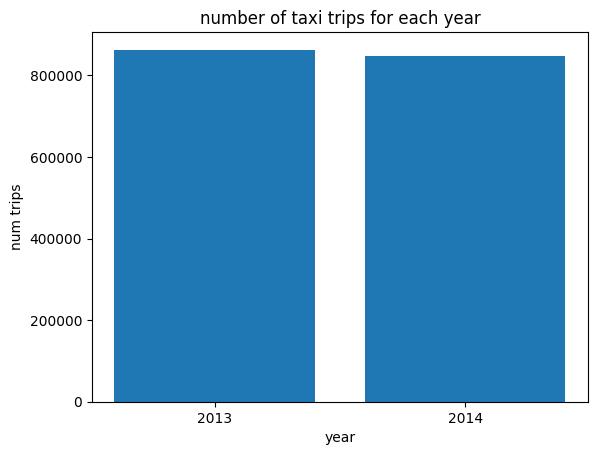

In [138]:
year_data = list(df_tr['YR'].value_counts().items())
plt.bar([str(x[0]) for x in year_data], [x[1] for x in year_data])
plt.title('number of taxi trips for each year')
plt.xlabel('year')
plt.ylabel('num trips')
plt.show()

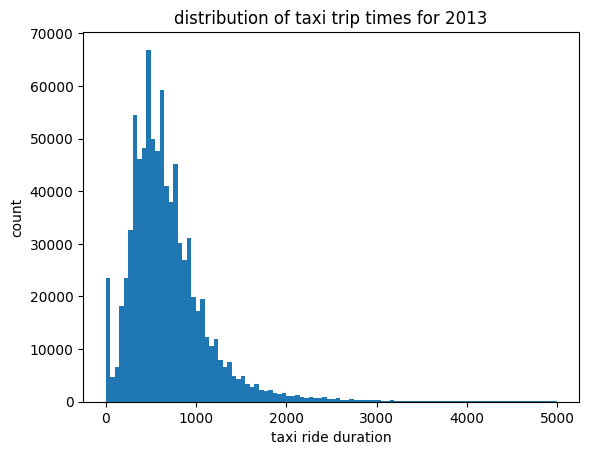

In [139]:
# get rid of disgusting outliers, who rides a taxi for 14 hours
plt.hist(df_tr[df_tr['YR'] == 2013]['LEN'][df_tr['LEN'] < 5000],100)
plt.title('distribution of taxi trip times for 2013')
plt.xlabel('taxi ride duration')
plt.ylabel('count')
plt.show()

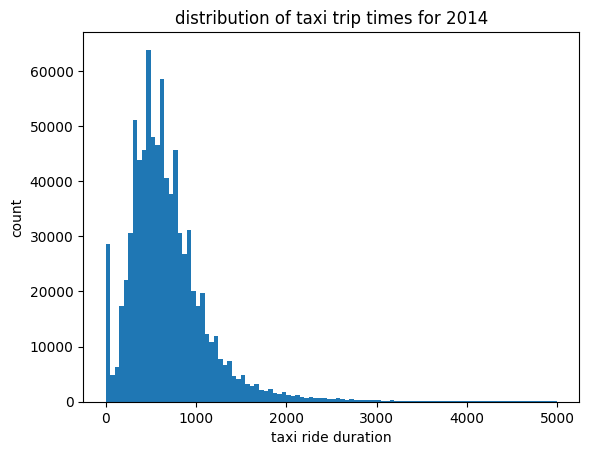

In [140]:
# get rid of disgusting outliers, who rides a taxi for 14 hours
plt.hist(df_tr[df_tr['YR'] == 2014]['LEN'][df_tr['LEN'] < 5000],100)
plt.title('distribution of taxi trip times for 2014')
plt.xlabel('taxi ride duration')
plt.ylabel('count')
plt.show()

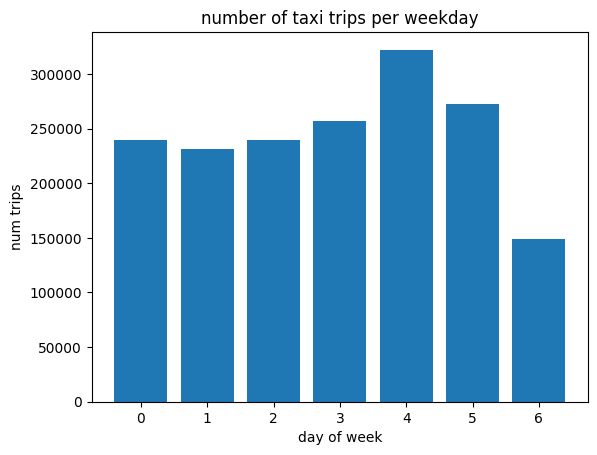

In [141]:
# trip density by days of week // 0 is monday // friday is most popoular - friday night drinking?
dow_data = list(df_tr['WK'].value_counts().items())
dow_data.sort(key = lambda x:x[0])
plt.bar([str(x[0]) for x in dow_data], [x[1] for x in dow_data])
plt.title('number of taxi trips per weekday')
plt.xlabel('day of week')
plt.ylabel('num trips')
plt.show()

In [142]:
eval(df_tr['POLYLINE'][0])[0]

[-8.618643, 41.141412]

In [143]:
eval(df_tr['POLYLINE'][0])[-1]

[-8.630838, 41.154489]

In [155]:
eval(df_tr['POLYLINE'][0])[0]

[-8.618643, 41.141412]

In [188]:
def start_coord(polyline):
    temp = eval(polyline)
    if len(temp)==0:
        return 0 
    return eval(polyline)[0]

In [191]:
# df_tr[df_tr['MISSING_DATA']==False]['POLYLINE'].apply(start_coord)

## Baseline

In [7]:
regr = RandomForestRegressor(max_depth=100, random_state=42, criterion = 'squared_error', n_jobs=-1)
regr.fit(X_train, y_train);

In [8]:
preds = regr.predict(X_test)
MSE(preds, y_test, squared=False)

782.554634729751

In [ ]:
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
random_regressor = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter = 20, scoring = 'neg_mean_absolute_error', cv = 5, n_jobs = -1)
random_regressor.fit(X_train, y_train)

In [ ]:
preds = random_regressor.predict(X_test)
MSE(preds, y_test)

## Deep Learning Model

In [145]:
# convert to tensors
X_train = torch.from_numpy(X_train.values).to(torch.float32)
y_train = torch.tensor(np.array(y_train)).to(torch.float32).reshape(-1,1)
X_test = torch.from_numpy(X_test.values).to(torch.float32)
y_test = torch.tensor(np.array(y_test)).to(torch.float32).reshape(-1,1)

In [134]:
X_train.values

array([['A', 30],
       ['C', 21],
       ['B', 2],
       ...,
       ['B', 28],
       ['A', 22],
       ['C', 26]], dtype=object)

In [146]:
data_train = TensorDataset(X_train, y_train)
data_test = TensorDataset(X_test, y_test)

In [147]:
batch_size = 64
num_workers = 2
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [148]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        eps = 1e-6
        loss = torch.sqrt(criterion(x, y) + eps)
        return loss

In [149]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(2,256),
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(256,64),
        )

        self.layer3 = nn.Sequential(
            nn.Linear(64,16),
        )
        
        self.layer4 = nn.Sequential(
            nn.Linear(16,1)
        )
        
    def forward(self, x):
        x = self.layer1(x)      
        x = self.layer2(x)      
        x = self.layer3(x)      
        x = self.layer4(x)    
        return x

In [150]:
# simplified model because my hair is leaving my head
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(2,8),
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(8,4),
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(4,1),
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

## Training

In [151]:
from tqdm import tqdm

# train step
criterion = RMSELoss()
net = model()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

for epoch in tqdm(range(10)):
    for x,y in train_loader:
        y_pred = net(x)
        loss  = criterion(y_pred, y)
        loss.backward()

        optimizer.step()

        optimizer.zero_grad()
        

    print('epoch {}, loss {}'.format(epoch, loss.item()))

print('Finished Training')

 10%|████▍                                       | 1/10 [00:13<01:57, 13.04s/it]

epoch 0, loss 430.94195556640625


 20%|████████▊                                   | 2/10 [00:25<01:39, 12.48s/it]

epoch 1, loss 833.1405639648438


 30%|█████████████▏                              | 3/10 [00:37<01:25, 12.26s/it]

epoch 2, loss 981.7571411132812


 40%|█████████████████▌                          | 4/10 [00:49<01:13, 12.17s/it]

epoch 3, loss 394.0018310546875


 50%|██████████████████████                      | 5/10 [01:01<01:00, 12.15s/it]

epoch 4, loss 508.04876708984375


 60%|██████████████████████████▍                 | 6/10 [01:13<00:48, 12.08s/it]

epoch 5, loss 378.97100830078125


 70%|██████████████████████████████▊             | 7/10 [01:25<00:36, 12.07s/it]

epoch 6, loss 336.1943359375


 80%|███████████████████████████████████▏        | 8/10 [01:37<00:24, 12.06s/it]

epoch 7, loss 277.4182434082031


 90%|███████████████████████████████████████▌    | 9/10 [01:49<00:12, 12.04s/it]

epoch 8, loss 688.0486450195312


100%|███████████████████████████████████████████| 10/10 [02:01<00:00, 12.13s/it]

epoch 9, loss 341.8160400390625
Finished Training
